# Кейс от Вконтакте: механизм ранжирования комментариев

Комментарии низкого качества ухудшают общее восприятие поста и сайта в целом. Именно поэтому важно ранжировать комментарии пользователей, а впоследствии и модерировать их, чтобы вначале показывать только те, которые действительно дополняют ценность контента.

**Задача:** разработать  механизм ранжирования комментариев на основе методов машинного обучения и в будущем создать более интересное и вовлекающее сообщество комментаторов.

Задача состоит из двух более мелких: представления текста и затем ранжирования.

*Условия*:
1. Использовать инструменты предобработки текста;
2. После обучения проанализировать полученные результаты и сформулировать полезные инсайты о том, что обычно содержит популярный комментарий;
3. Мерика качества - NDCG, но можно использовать другие методы оценки.

# Подготовка данных и EDA


Перед тем, как перейти к обучению модели, необходимо предварительно изучить и обработать текстовые данные.

## План предобработки: 
 1. Поиск и замена ссылок на специальный токен
 2. Очистка текста от символов и приведение его к нижнему регистру
 3. Токенизация и лемматизация текста
 4. Проверка качества

## Импорт библиотек

In [ ]:
!pip install transformers sentencepiece sacremoses

In [ ]:
from google.colab import drive
from google.colab import files
import warnings
import os
import json

import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
%matplotlib inline

from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
import gensim
from gensim.utils import tokenize
from gensim.utils import lemmatize
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import STOPWORDS 

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud
from collections import Counter

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# игнорируем предупреждения
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

## Знакомство с данными

In [ ]:
# подключение гугл диска
drive.mount('/content/drive')

Mounted at /content/drive


**Чтение данных (исходный или предобработанный файлы - из json или csv)**

In [ ]:
# чтение с Google Drive исходной ОБУЧАЮЩЕЙ выборки (пользуемся, когда работаем с нуля - скачиваем исходный .jsonl файл)
data_train = []
with open('/content/drive/MyDrive/ranking_train.jsonl', 'r') as f: # путь в подключенном диске
    for line in f:
        sample = json.loads(line)
        text = sample['text']
        comments = sample['comments']
        for comment in comments:
            comment_text = comment['text']
            comment_score = comment['score']
            data_train.append({'text': text, 'comment_text': comment_text, 'comment_score': comment_score})

# датафрейм с результатами
df_train = pd.DataFrame(data_train)

In [ ]:
# чтение csv-файла ОБУЧАЮЩЕЙ выборки с предобработанными токенами комментариев в отдельном столбце
train_data_path_1 = 'clear_train.csv'
train_data_path_2 = '/content/drive/MyDrive/clear_train.csv'

# если файла нет в сессионном хранилище ноутбука, скачиваем с диска
if os.path.exists(train_data_path_1):
    data_train = pd.read_csv(train_data_path_1, index_col=0)
else: 
    data_train = pd.read_csv(train_data_path_2, index_col=0)

# датафрейм с результатами
df_train = pd.DataFrame(data_train)

In [ ]:
# чтение с Google Drive исходной ТЕСТОВОЙ выборки (пользуемся, когда работаем с нуля - скачиваем исходный .jsonl файл)
data_test = []
with open('/content/drive/MyDrive/ranking_test.jsonl', 'r') as f: # здесь указать путь в подключенном диске
    for line in f:
        sample = json.loads(line)
        text = sample['text']
        comments = sample['comments']
        for comment in comments:
            comment_text = comment['text']
            comment_score = comment['score']
            data_test.append({'text': text, 'comment_text': comment_text, 'comment_score': comment_score})

# датафрейм с обучающими данными
df_test = pd.DataFrame(data_test)

In [ ]:
# чтение csv-файла ТЕСТОВОЙ выборки с предобработанными токенами комментариев в отдельном столбце
test_data_path_1 = 'clear_test.csv'
test_data_path_2 = '/content/drive/MyDrive/clear_test.csv'

if os.path.exists(test_data_path_1):
    data_test = pd.read_csv(test_data_path_1, index_col=0)
else: 
    data_test = pd.read_csv(test_data_path_2, index_col=0)

# датафрейм с обучающими данными
df_test = pd.DataFrame(data_test)

In [ ]:
# Функция выводит основную иннформацию о датафрейме

def hello_data(data):
    display(data.head(5))
    print(data.info())   
    print(data.describe())
    print('Дубликатов в таблице:', data.duplicated().sum())
    print('Уникальных текстов в столбце text:', data['text'].nunique())
    print('Форма таблицы:{}'.format(data.shape))
    print('Распределение comment_score:{}', data.comment_score.value_counts())

    return (data.isna().mean()*100).sort_values(ascending=False).to_frame().rename(
    columns = {0:'Процент_пропусков'}).style.background_gradient('coolwarm').format("{:.1f}")

In [ ]:
hello_data(df_train)

,text,comment_text,comment_score
0,How many summer Y Combinator fundees decided n...,Going back to school is not identical with giv...,0
1,How many summer Y Combinator fundees decided n...,There will invariably be those who don't see t...,1
2,How many summer Y Combinator fundees decided n...,For me school is a way to be connected to what...,2
3,How many summer Y Combinator fundees decided n...,I guess it really depends on how hungry you ar...,3
4,How many summer Y Combinator fundees decided n...,I know pollground decided to go back to school...,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440535 entries, 0 to 440534
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   text           440535 non-null  object
 1   comment_text   440535 non-null  object
 2   comment_score  440535 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.1+ MB
None
       comment_score
count  440535.000000
mean        2.000000
std         1.414215
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Дубликатов в таблице: 0
Уникальных текстов в столбце text: 87664
Форма таблицы:(440535, 3)
Распределение comment_score:{} 0    88107
1    88107
2    88107
3    88107
4    88107
Name: comment_score, dtype: int64


,Процент_пропусков
text,0.0
comment_text,0.0
comment_score,0.0


На каждый пост приходится по 5 комментариев, распределение рангоы комментариев сбалансированно. Дубликатов и пропусков не обнаружено, приступим к предобработке данных.

## Предобработка данных

 План предобработки: 
 1. Найти и заменить ссылки на специальный токен
 2. Убрать символы из текста и привести его к нижнему регистру
 3. Токенизировать текст
 4. Лемматизировать текст и убрать стоп-слова

 Мы будем удалять стоп-слова, чтобы уменьшить количество признаков в модели: это поможетсделать обработку текста более быстрой и эффективной. Для этого используем библиотеку Gensim, тк она содержит множество предобученных стоп-слов, которые не являются жестко заданными, а вычисляются на основе анализа частотности слов в текстах(это позволяет избавиться от шума в данных и улучшить качество классификации).

In [ ]:
# Выгружаем стоп-слова из  gensim
all_stopwords = STOPWORDS.union(set(["isn't", "don't", "doesn't", "ve", "am", "d", 
                                     "s", "t", "m", "x", "wa", "ha", "c", "e", "f"])) 
print(f'Количество наших стоп-слов:', len(all_stopwords))
print(f'Всего стоп-слов из gensim:', len(STOPWORDS))

Количество наших стоп-слов: 351
Всего стоп-слов из gensim: 337


In [ ]:
# функция для обработки комментария (токенизация, лемматизация, стоп-слова, замена регулярками)

wnl = WordNetLemmatizer() # Объект - лемматизатор

def comment_cleaning(comment):
    # словарь для предобработанного текста
    preprocessed_text = []
    # находим все ссылки в тексте и заменяем их на специальный токен "URL"
    comment = re.sub(r'http\S+', 'URL', comment)
    # оставляем латинские символы, пробелы и токен "URL"
    comment = re.sub(r'[^a-zA-Z URL]', ' ', comment)
    # нижний регистр и токенизация
    tokens = tokenize(comment.lower())
    # лемматизация
    lemmatized_tokens = [wnl.lemmatize(w) for w in tokens]
    for token in lemmatized_tokens:
        if token not in all_stopwords:
            preprocessed_text.append(token)
    return preprocessed_text

# Cоединяем очищенные комментарии в чистый текст
def join_words(words_list):
    text = " ".join(words_list)
    return text

In [ ]:
# предобработка ОБУЧАЮЩЕЙ (ranking_train) выборки
# Добавление колонки с предобработанными комментариями в df_train
df_train['comment_clear_list'] = df_train['comment_text'].apply(lambda x: comment_cleaning(x))
df_train['comment_clear'] = df_train['comment_clear_list'].apply(join_words)    

In [ ]:
display(df_train.head())

,text,comment_text,comment_score,comment_clear_list,comment_clear
0,How many summer Y Combinator fundees decided n...,Going back to school is not identical with giv...,0,"[going, school, identical, giving, founder, sc...",going school identical giving founder school w...
1,How many summer Y Combinator fundees decided n...,There will invariably be those who don't see t...,1,"[invariably, success, set, fall, original, pat...",invariably success set fall original path foun...
2,How many summer Y Combinator fundees decided n...,For me school is a way to be connected to what...,2,"[school, way, connected, going, real, world, e...",school way connected going real world entered ...
3,How many summer Y Combinator fundees decided n...,I guess it really depends on how hungry you ar...,3,"[guess, depends, hungry, believe, product, sch...",guess depends hungry believe product school mo...
4,How many summer Y Combinator fundees decided n...,I know pollground decided to go back to school...,4,"[know, pollground, decided, school, getting, y...",know pollground decided school getting y combi...


In [ ]:
# сохранение датафрейма TRAIN с токенами комментариев в .csv
df_train.to_csv('/content/drive/MyDrive/clear_train.csv')

In [ ]:
# предобработка ТЕСТОВОЙ (ranking_test) выборки

# Добавление колонки с предобработанными комментариями
df_test['comment_clear_list'] = df_test['comment_text'].apply(lambda x: comment_cleaning(x))
# получаем чистые токены из комментариев в виде сплошного текста
df_test['comment_clear'] = df_test['comment_clear_list'].apply(join_words) 

In [ ]:
display(df_test.head())

,text,comment_text,comment_score,comment_clear_list,comment_clear
0,"iOS 8.0.1 released, broken on iPhone 6 models,...",I&#x27;m still waiting for them to stabilize w...,None,"[waiting, stabilize, wifi, ipad, sith, io, qua...",waiting stabilize wifi ipad sith io quality st...
1,"iOS 8.0.1 released, broken on iPhone 6 models,...","For those who upgraded, no need to do a restor...",None,"[upgraded, need, restore, option, click, quot,...",upgraded need restore option click quot update...
2,"iOS 8.0.1 released, broken on iPhone 6 models,...",Upgraded shortly after it was released and suf...,None,"[upgraded, shortly, released, suffered, conseq...",upgraded shortly released suffered consequence...
3,"iOS 8.0.1 released, broken on iPhone 6 models,...",I think they were under a lot of pressure on t...,None,"[think, lot, pressure, healthkit, big, flagshi...",think lot pressure healthkit big flagship io f...
4,"iOS 8.0.1 released, broken on iPhone 6 models,...",Fix for those who already updated: http:&#x2F...,None,"[fix, updated, url]",fix updated url


In [ ]:
# сохранение датафрейма TEST с токенами комментариев в csv
df_test.to_csv('/content/drive/MyDrive/clear_test.csv')

## Проверка качества

Создадим облако слов, чтобы проверить качество очищенного текста

In [ ]:
# Объединяем все списки слов в один список
all_words = [word for sublist in df_train['comment_clear_list'] for word in sublist]

# Создаем объект WordCloud
wordcloud = WordCloud(background_color='white', width=800, height=400)

# Создаем объект Counter для подсчета частот каждого слова
word_counts = Counter(all_words)

# Создаем словарь с частотами каждого слова
word_frequencies = dict(word_counts)

# Создаем объект WordCloud и отображаем облако слов
wordcloud = WordCloud(background_color='white', width=2400, height=1200)
wordcloud.generate_from_frequencies(word_frequencies)

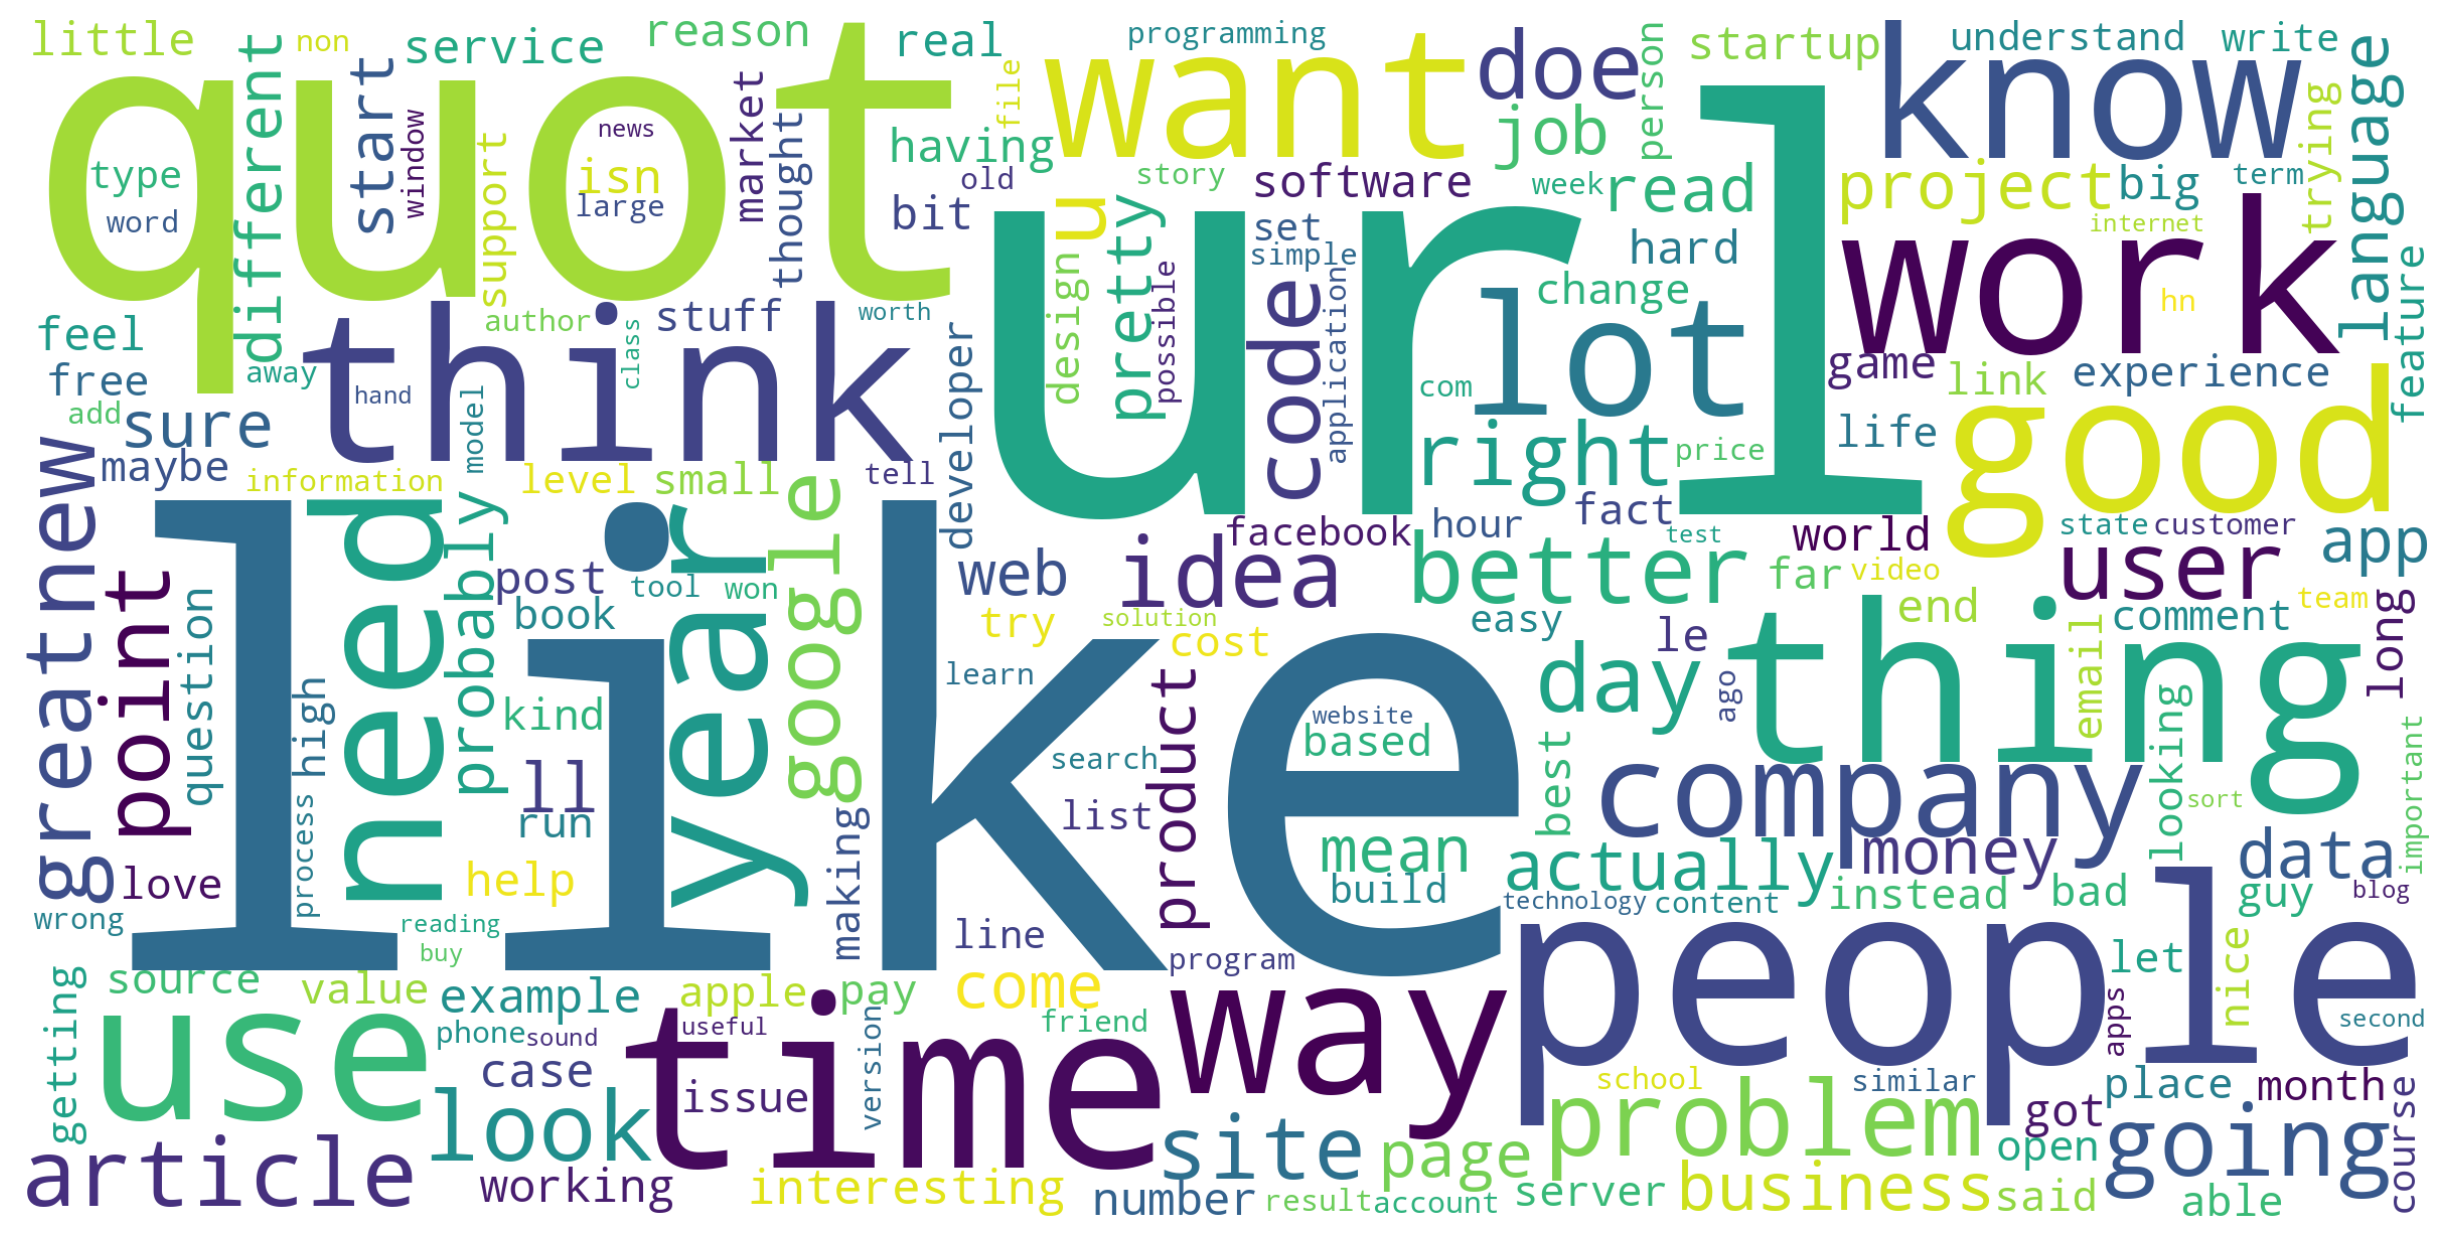

In [ ]:
plt.figure(figsize=(16, 8), dpi=200)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Облако слов показывает нам частотное распределение слов в тексте или наборе текстов.
По нему мы видим, что пользователи часто используют в комментариях ссылки. В комментариях обсуждают facefook, работу, бизнес, программирование и многое другое.

Мы также видим, что облако слов *чистое*, в нём не встречаются отдельные буквы и слоги\артикли. Данные готов для дальнейшей работы с ними.

Сохраним данные в csv-файл.


In [ ]:
df = df_train.copy()
df.to_csv('clear_train.csv', index=False)

# Загрузка файла на компьютер
files.download('clear_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Промежуточные итоги

C помощью библиотеки Gensim, Re и Nltk, нам удалось очистить комментарии, а также лемматизировать и токенизировать их. Используя облако слов мы проверили качество предобработки данных и убедились, что можем двигаться дальше.

Файл с данными для обучения лежит в файле clear_train.csv.